# Тест отдельной модели для кошельков без выходящих транзакций

Используем 2 лучших классификатора из прошлых экспериментов экспериментов

- RandomForestClassifier(n_estimators=150), precicion: 0.8608339728830903, recall: 0.801954242135367

- RF + XGBoost stacking, precicion=0.82435319, recall=0.82769304,

In [77]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set(style="darkgrid")

np.random.seed(0)
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from utils import get_best_threshold

In [78]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [79]:
%autoreload 2

from utils import (
    prepare_wallets_features_data,
    prepare_wallets_features_data_new,
    get_training_data,
    print_confusion_matrix,
    get_prepared_train_test,
)

In [80]:
# wallets_features = pd.read_csv("../dataset/custom/wallets_features_aggregated.csv")
wallets_features = pd.read_csv("../dataset/custom/features_fixed/wallets_features_with_users_agg.csv")

prep_data = prepare_wallets_features_data_new(wallets_features, type="raw")
X_train, X_test, y_train, y_test = get_training_data(prep_data, no_unknown=False)

In [81]:
wallets_features.shape

(822942, 56)

In [82]:
y_train.value_counts(), y_test.value_counts()

(class
 0    566103
 1      9956
 Name: count, dtype: int64,
 class
 0    242573
 1      4310
 Name: count, dtype: int64)

In [224]:
# prep_data = prepare_wallets_features_data(wallets_features, type="raw")
# X_train, X_test, y_train, y_test = get_training_data(prep_data, no_unknown=False)

train_data_raw = pd.read_csv("../dataset/custom/features_fixed/wallets_features_with_users__train.csv")
test_data_raw = pd.read_csv("../dataset/custom/features_fixed/wallets_features_with_users__test.csv")

In [225]:
train_data_raw[train_data_raw["outcoming_tx_cnt"] == 0].shape, train_data_raw.shape
train_data_raw = train_data_raw[train_data_raw["outcoming_tx_cnt"] == 0]
test_data_raw = test_data_raw[test_data_raw["outcoming_tx_cnt"] == 0]
train_data_raw.shape, test_data_raw.shape

((288507, 56), (305316, 56))

In [180]:
test_data_raw[test_data_raw["addrId"].isin(train_data_raw["addrId"])].shape, test_data_raw.shape
test_data_raw_unique = test_data_raw[~test_data_raw["addrId"].isin(train_data_raw["addrId"])]

In [181]:
X_train_1, X_test_1, y_train_1, y_test_1 = get_prepared_train_test(
    train_data_raw,
    test_data_raw,
)

# X_train_1, X_test_1_unique, y_train_1, y_test_1_unique = get_prepared_train_test(
#     train_data_raw,
#     test_data_raw_unique,
# )

y_train_1.value_counts(), y_test_1.value_counts()

(class
 0    336145
 1      1502
 Name: count, dtype: int64,
 class
 0    303854
 1      1462
 Name: count, dtype: int64)


        Best threshold: 0.4737368421052632
        Best F1: 0.3587756683456025, precicion: 0.22256048710142606, recall: 0.9247669773635153
        


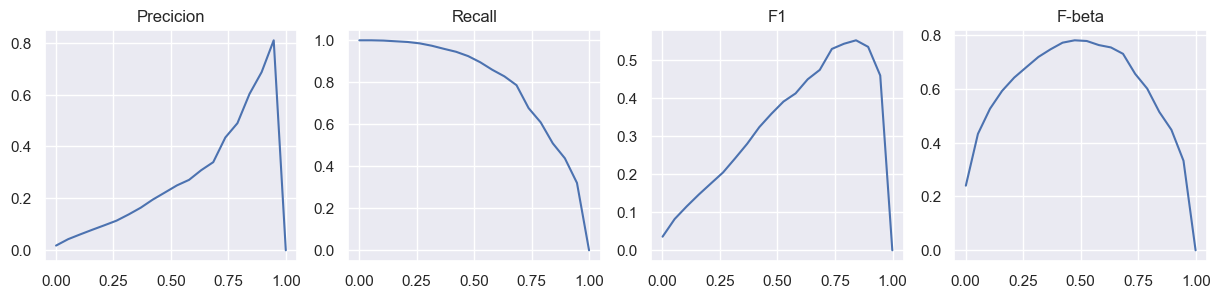

In [221]:
import xgboost as xgb 


X_train_1, X_test_1, y_train_1, y_test_1 = get_prepared_train_test(
    train_data_raw,
    test_data_raw,
)

column_transformer = ColumnTransformer(
    transformers=[
        ('min_max_scale', MinMaxScaler(), list(set(X_train_1.columns) - set(["addrId", "class"]))),
    ]
)

pipeline = Pipeline(steps=[
    ('transformers', column_transformer),
    # ('rf', RandomForestClassifier(n_estimators=150, class_weight={0: 1, 1: 50}, min_samples_leaf=10))
    ('rf', xgb.XGBClassifier(n_estimators=200, learning_rate=0.1, scale_pos_weight=30, min_samples_leaf=2))
])
# RandomForestClassifier(min_samples_leaf=
model = pipeline.fit(X_train_1, y_train_1)
y_pred = model.predict_proba(X_test_1)[:, 1]
y_pred_train = model.predict_proba(X_train_1)[:, 1]

y_pred_vals = model.predict(X_test_1)

# res = get_best_threshold(y_pred, y_test_1, return_hists=True)
res1 = get_best_threshold(y_pred_train, y_train_1, return_hists=True)


        Best threshold: 0.4212105263157895
        Best F1: 0.050936768149882905, precicion: 0.027698185291308502, recall: 0.31636363636363635
        


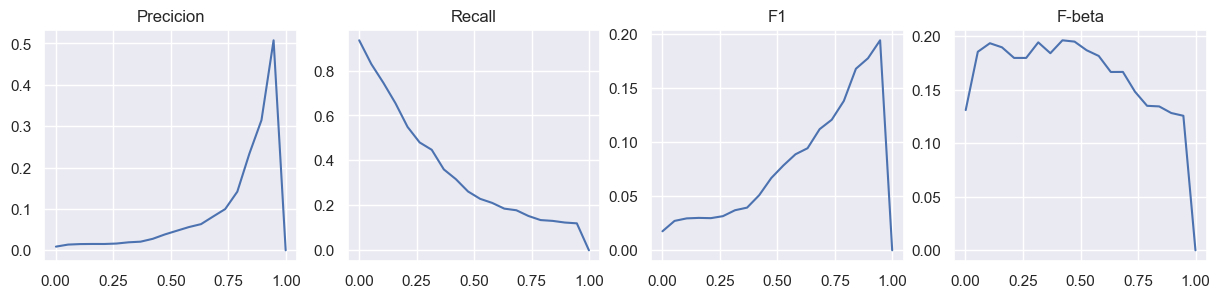

In [226]:
res = get_best_threshold(y_pred, y_test_1, return_hists=True)

In [230]:
print_confusion_matrix(y_pred, 0.72, y_test_1)

	real 1	real 0
pred 1	43	436	
pred 0	232	91265	


In [231]:
print_confusion_matrix(y_pred, 0.2, y_test_1)

	real 1	real 0
pred 1	153	10111	
pred 0	122	81590	


In [217]:
y_pred_10 = ((y_pred >= 0.7) == 0) * (y_test_1 == 1)
y_pred_10[y_pred_10 == True][:20]

5433     True
5438     True
8773     True
8774     True
9786     True
9920     True
9975     True
10315    True
11503    True
11505    True
11506    True
11751    True
12361    True
12804    True
13074    True
13116    True
13117    True
14148    True
14355    True
15463    True
Name: class, dtype: bool

In [216]:
rf_model = pipeline.named_steps['rf']
for ind in np.argsort(rf_model.feature_importances_)[::-1]:
    print((X_train_1.columns)[ind], rf_model.feature_importances_[ind])

incoming_tx_fees_min 0.5850086
outcoming_tx_cnt 0.057423156
btc_received_total 0.050988484
input_address_cnt 0.050249167
big_inp_addr 0.044299677
btc_sent_gini 0.036821537
btc_sent_min 0.027331408
outcoming_tx_input_address_cnt_mean 0.026012674
btc_received_mean 0.023881396
incoming_tx_output_address_cnt_mean 0.020188406
incoming_tx_input_address_cnt_mean 0.019442763
btc_received_gini 0.016973792
incoming_tx_ts_gini 0.016517028
btc_sent_total 0.013120788
outcoming_tx_fees_mean 0.011741144
output_address_cnt 0.0
outcoming_tx_fees_max 0.0
btc_received_min 0.0
btc_received_max 0.0
outcoming_tx_ts_gini 0.0
incoming_tx_cnt 0.0
outcoming_tx_ts_cnt 0.0
outcoming_tx_fees_total 0.0
outcoming_tx_whole_fee_4_cnt 0.0
lifetime_in_blocks 0.0
incoming_tx_fees_max 0.0
incoming_tx_whole_fee_4_cnt 0.0
outcoming_tx_fees_min 0.0
incoming_tx_ts_cnt 0.0
btc_sent_mean 0.0
big_bct_received 0.0
outcoming_tx_output_address_cnt_mean 0.0
btc_sent_max 0.0


In [218]:
y_pred[5433], y_test_1[5433], X_test_1.loc[5433]

(0.68753594,
 1,
 btc_received_total                      1.715963
 btc_received_min                        1.715963
 btc_received_max                        1.715963
 btc_received_mean                       1.715963
 incoming_tx_cnt                         1.000000
 incoming_tx_input_address_cnt_mean      1.000000
 incoming_tx_output_address_cnt_mean     2.000000
 btc_received_gini                       0.000000
 input_address_cnt                       1.000000
 incoming_tx_fees_min                    0.000200
 incoming_tx_fees_max                    0.000200
 incoming_tx_whole_fee_4_cnt             1.000000
 btc_sent_total                          0.000000
 btc_sent_min                            0.000000
 btc_sent_max                            0.000000
 btc_sent_mean                           0.000000
 outcoming_tx_cnt                        0.000000
 outcoming_tx_output_address_cnt_mean    0.000000
 outcoming_tx_input_address_cnt_mean     0.000000
 btc_sent_gini                   

### with users

In [ ]:
train_data_raw = pd.read_csv("../dataset/custom/features_fixed/wallets_features__train.csv")
test_data_raw = pd.read_csv("../dataset/custom/features_fixed/wallets_features__test_new_split.csv")

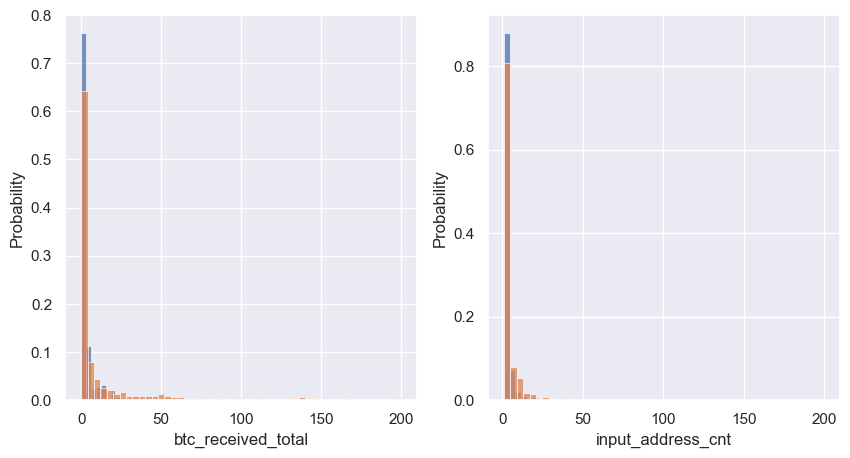

In [167]:
def plot_metrics(licit, illicit, cutoff, ax, title=""):
    sns.histplot(
        licit[licit <= cutoff],
        ax=ax,
        bins=50,
        stat="probability"
    )
    ax.set_title(title)

    sns.histplot(
        illicit[illicit <= cutoff],
        ax=ax,
        bins=50,
        stat="probability"
    )
fig, ax = plt.subplots(1,2, figsize=(10,5))

plot_metrics(
    train_data_raw[train_data_raw["class"] == 1]["btc_received_total"],
    train_data_raw[train_data_raw["class"] != 1]["btc_received_total"],
    cutoff=200,
    ax=ax[0]
)

plot_metrics(
    train_data_raw[train_data_raw["class"] == 1]["input_address_cnt"],
    train_data_raw[train_data_raw["class"] != 1]["input_address_cnt"],
    cutoff=200,
    ax=ax[1]
)

In [165]:
train_data_raw["input_address_cnt"]

308582     1.0
308583    11.0
308584     2.0
308585     1.0
308586     1.0
          ... 
646224     6.0
646225     3.0
646226     3.0
646227     3.0
646228     3.0
Name: input_address_cnt, Length: 337647, dtype: float64

<Axes: >

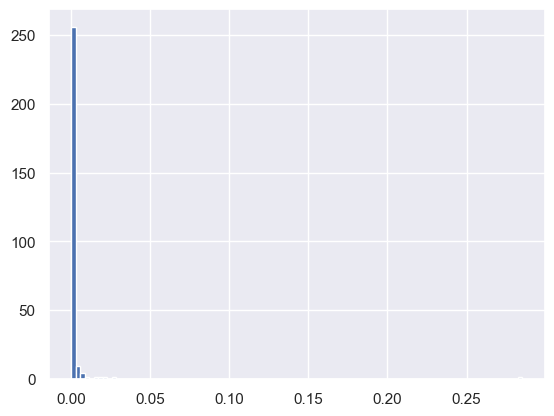

In [48]:
test_data_raw[test_data_raw["class"] == 1]["incoming_tx_fees_mean"].hist(bins=100)